<a href="https://colab.research.google.com/github/jakubtwalczak/Muller_Guido_Introduction_to_ML/blob/main/Rozdzia%C5%82_6_%C5%81a%C5%84cuchy_algorytm%C3%B3w_i_potoki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Większość aplikacji do uczenia maszynowego wymaga nie tylko zastosowania pojedynczego algorytmu, ale również połączenia wielu etapów przetwarzania danych i modeli. Uprościć ten proces można, implementując łańcuch transformacji - tzw. potok. Tworzenie łańcuchów transformacji i modeli jest możliwe dzięki użyciu klasy Pipeline.

Poniżej przykład dzielenia danych, obliczania minimum i maksimum, skalowania danych i treningu modelu - zbiór danych Cancer, klasyfikator SVM.

In [5]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97
Test score: 0.97


# Wybór parametrów z przetwarzaniem wstępnym.

Gdy chcemy znaleźć najlepsze parametry dla modelu, używając klasy GridSearchCV, naiwne podejście do tego może wyglądać następująco:

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)
grid.fit(X_train_scaled, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Test set score: {grid.score(X_test_scaled, y_test):.2f}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.98
Test set score: 0.97
Best parameters: {'C': 1, 'gamma': 1}
Best cross-validation score: 0.98
Test set score: 0.97
Best parameters: {'C': 1, 'gamma': 1}


Aby się dowiedzieć, jak przeskalować dane, użyliśmy wszystkich danych ze zbioru treningowego. Następnie, aby przeprowadzić przeszukiwanie siatki, skorzystaliśmy z przeskalowanych danych uczących. Część testowa służy do zmierzenia, jak nowe dane będą wyglądały w modelu wytrenowanym w części uczącej. Jednak już skalując dane, użyliśmy informacji zawartych w podzbiorze testowym, jako że te dane były wykorzystane w procesie kroswalidacji. Podzbiór testowy w każdym podziale walidacji krzyżowej jest częścią zbioru treningowego, a żeby znaleźć właściwe skalowanie danych, sięgnęliśmy po informacje z całego zbioru uczącego.

Różni się to od tego, jak nowe dane przedstawiają się w modelu. Jeżeli zaobserwujemy nowe dane, nie zostaną one wykorzystane do skalowania danych uczących; mogą mieć inne minimum i maksimum niż dane uczące.

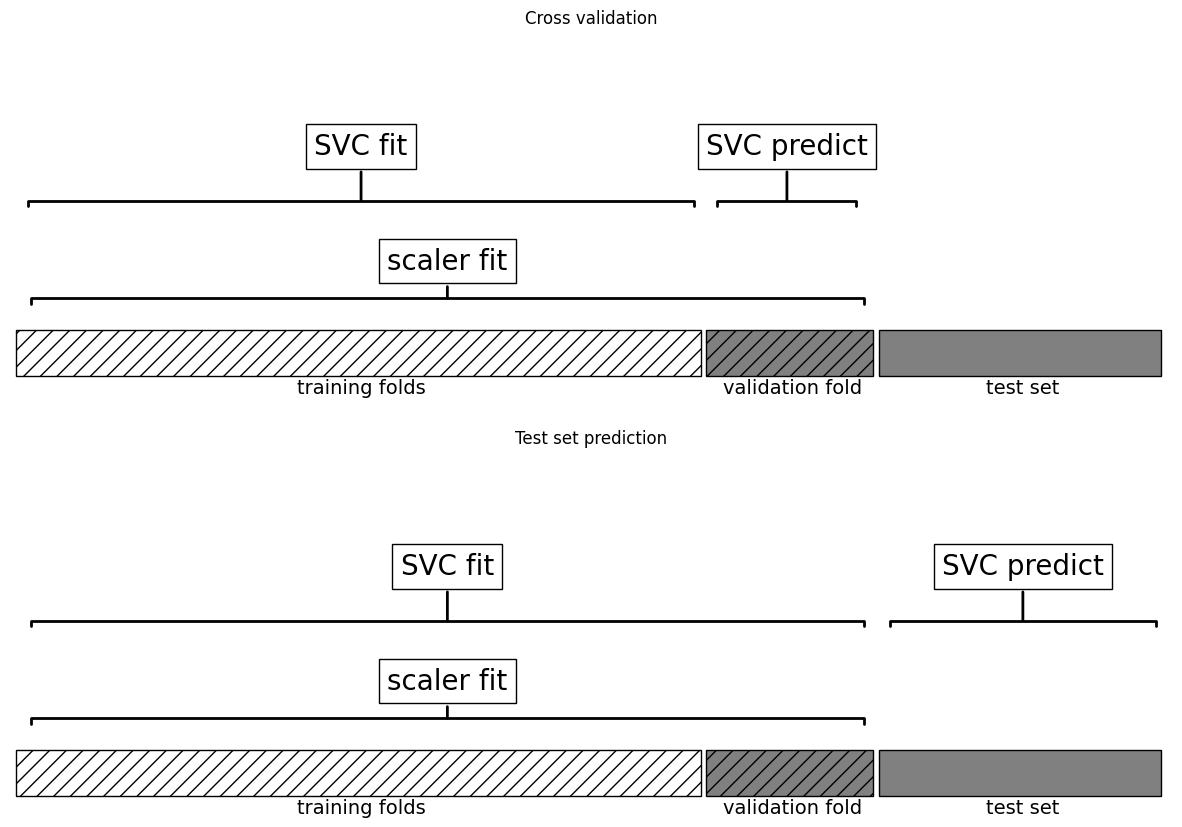

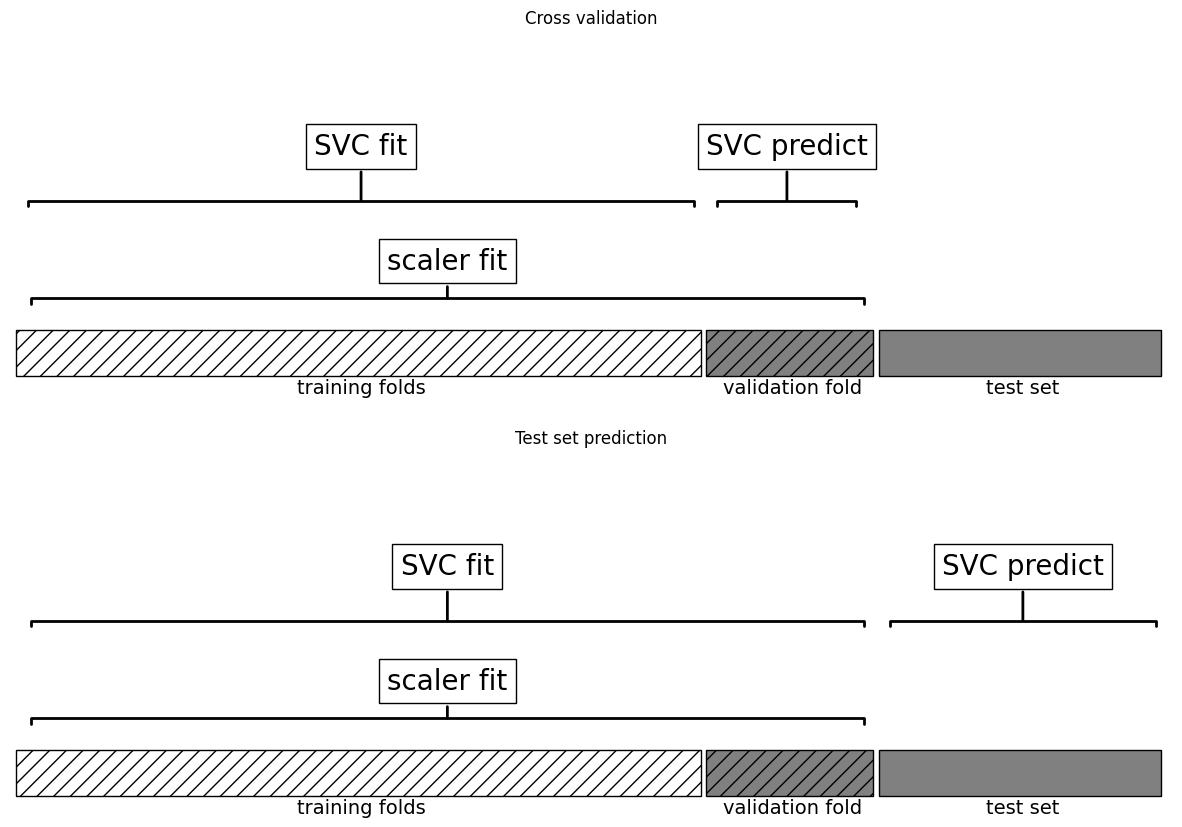

In [7]:
import mglearn

mglearn.plots.plot_improper_processing()

Podziały w walidacji krzyżowej nie odzwierciedlają już poprawnie wyglądu nowych danych w procesie modelowania. Informacje z tych danych przeciekły już do procesu modelowania, przez co wynik walidacji krzyżowej jest zbyt optymistyczny i zapewne doprowadzi do wyboru nieoptymalnych parametrów.

Żeby ten problem obejść, należy podzielić dane przed wykonaniem jakiegokolwiek przetwarzania wstępnego. Każdy proces wyodrębniający wiedzę z danych, powinien być stosowany wyłącznie na danych uczących. Walidacja krzyżowa powinna być "najbardziej zewnętrzną pętlą" przetwarzania.

Aby to osiągnąć, przy użyciu walidacji krzyżowej i przeszukiwania siatki możemy użyć klasy Pipeline. Pozwala ona na "sklejanie" wielu etapów przetwarzania w jeden estymator.

# Tworzenie potoków.

Potok tworzymy jako instancję klasy Pipeline z listą kroków, przekazywanych jako krotkę, która zawiera nazwę oraz instancję estymatora. Zdefiniowaliśmy dwa kroki - pierwszy zawiera nazwę "scaler" i instancję klasy MinMaxScaler, drugi - nazwę "svm" i instancję klasy SVC. Na takim obiekcie możemy wywołać metodę fit; powoduje ona wywołanie metody fit dla wszystkich kroków potoku. Aby ocenić dane testowe, wywołujemy metodę score.

In [8]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print(f"Test score: {pipe.score(X_test, y_test):.2f}")

Test score: 0.97
Test score: 0.97


Metoda score dla obiektu klasy Pipeline najpierw spowodowała przeskalowanie danych przy użyciu skalera, a następnie wywołanie metody score dla modelu SVM przy użyciu przeskalowanych danych testowych. Przy pomocy potoku redukujemy kod potrzebny do procesu przekształcenia wstępnego i modelowania. Główną zaletą korzystania zeń jest jednak to, że możemy użyć tego pojedynczego estymatora w funkcji cross_val_score lub w klasie GridSearchCV.